# Week 7: The Finite Difference Method

## Library Imports Go Here

In [341]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.sparse as sparse
import random

## A Generic Finite Difference Matrix Creation Function

<font color = blue>
We are interested in solving the general equation type

$$
A(x)u'' + B(x)u' + C(x)u = \lambda u
$$

subject to the boundary conditions

$$
u(0) = u(x_{\infty}) = 0
$$

(by which we mean that we want to find both the eigenvalue $\lambda$ and the eigenfunction $u(x)$.)  The basic approach used today will be to transform this equation into a matrix equation in the form

$$
\mathbb{M}\vec{u} = \lambda\vec{u}
$$

and the focus will be on generating the matrix $\mathbb{M}$, which we can then use existing python functions from the scipy.sparse and the scipy.linalg modules to analyze.

### A Matrix Generating Function

<font color = blue>
    
Construct a function that takes as inputs the three functions $A(x)$, $B(x)$, and $C(x)$, along with `matrix_size` = $N$, the total size-length of the matrix and $x_{\infty}$ the value of "numerical infinity", and outputs the matrix $\mathbb{M}$ (as an array.)  Test your matrix generator with $A = B = C = 1$, $x_{\infty} = 1$, and $N = 5$, and show the result.  Confirm that the entries to the matrix are correct with calculations included in a **discussion**.

In [346]:
def matrix_gen(A, B, C, matrix_size, x_inf):
    """
    Function that generates our matrix M

    A : function A(x)
    B : function B(x)
    C : function C(x)
    matrix_size : the size of the matrix M
    x_inf : numerical infinity

    returns : matrix M as an array
    """
    M = np.zeros((matrix_size, matrix_size))
    del_x = x_inf/(matrix_size + 1)
    x_j = 0
    for i in range(matrix_size):
        x_j += del_x
        M[i][i] = C(x_j) - (2 * A(x_j)/ (del_x**2))
        if i == 0:
            M[i][i + 1] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
        elif i == matrix_size - 1:
            M[i][i - 1] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
        else:
            M[i][i + 1] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            M[i][i - 1] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))

    return M

def A(x):
    return 1

matrix_gen(A, A, A, 5, 1)

array([[-71.,  39.,   0.,   0.,   0.],
       [ 33., -71.,  39.,   0.,   0.],
       [  0.,  33., -71.,  39.,   0.],
       [  0.,   0.,  33., -71.,  39.],
       [  0.,   0.,   0.,  33., -71.]])

To confirm that this result is correct I can calculate M[i][i + 1], M[i][i], and M[i][i - 1] because they will not change as we go through the array.
$$M[i][i - 1] = \frac{1}{\frac{1}{36}} - \frac{1}{\frac{1}{3}} =  36 - 3 = 33$$ 
$$M[i][i] = 1 - \frac{2}{\frac{1}{36}} =  1 - 72 = -71$$
$$M[i][i - 1] = \frac{1}{\frac{1}{36}} + \frac{1}{\frac{1}{3}} =  36 + 3 = 39$$ 
As we can see these match up to the outputted results in the array M.

### A Sparse Matrix Generating Function

<font color = blue>
There are many numerical methods that find the eigenvalues and eigenvectors of a matrix, but they are definitely not all created equal.  Even though we aren't learning the algorithms behind these methods, it is still useful to consider some of their differences.

```
```

There are a set of algorithms specifically designed to work on matrices which are "sparse", meaning that most of the elements in them are zero.  However, in order to use these algorithms, we have to create and store the matrix in a way other than the standard numpy array.  What we want to do here is write a second function for creating a matrix, but this time store it as a "sparse" matrix type.  

```
```

To do this you will need to use the library scipy.sparse.  There is more than one sparse matrix type (the differences are in how the data is stored in your computer), but the easiest one to create is the "coo" type, so you will need to use the function coo_matrix in the scipy.sparse library.  

```
```

Once you have your function for creating the matrix, you can take its output and convert it into a standard array using .toarray().  (This is helpful for making sure this code produces the same matrix you've just confirmed is correct in the previous code -- but make sure your function doesn't do this internally, because that will defeat the point!)

In [427]:
def sparse_matrix(A, B, C, matrix_size, x_inf):
    """
    Function that efficiently generates our matrix M using sparse matrix techniques

    A : function A(x)
    B : function B(x)
    C : function C(x)
    matrix_size : the size of the matrix M
    x_inf : numerical infinity

    returns : matrix M as an array
    """
    rows = np.array([i + 1 for i in range(matrix_size - 2) for j in range(3)])
    rows = np.append([0, 0], rows)
    rows = np.append(rows, [matrix_size - 1, matrix_size - 1])

    n = matrix_size * 3 - 6  # Length of the array you want
    cols = np.repeat(np.arange(n//3 + 2), 3)[:n] + np.tile([0,1,2], n//3 + 1)[:n]
    cols = np.append([0, 1], cols)
    cols = np.append(cols, [matrix_size - 2, matrix_size - 1])

    del_x = x_inf/(matrix_size + 1)
    x_j = 0
    
    data = np.zeros(len(cols))
    k = 0
    for i in range(matrix_size):
        if i == 0:
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        elif i == matrix_size - 1:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
        else:
            data[k] = (A(x_j)/del_x**2) - (B(x_j)/(2 * del_x))
            k += 1
            data[k] = C(x_j) - (2 * A(x_j)/ (del_x**2))
            k += 1
            data[k] = (A(x_j)/del_x**2) + (B(x_j)/(2 * del_x))
            k += 1
        x_j += del_x
    return sparse.coo_matrix((data, (rows, cols)), shape=(matrix_size, matrix_size))
    
sparse_matrix(A, A, A, 5, 1).toarray()

array([[ 71., -39.,   0.,   0.,   0.],
       [-33.,  71., -39.,   0.,   0.],
       [  0., -33.,  71., -39.,   0.],
       [  0.,   0., -33.,  71., -39.],
       [  0.,   0.,   0., -33.,  71.]])

### The Comparison

<font color = blue>
    
Here, we will compare the efficiency of a method which uses sparse techniques with one that doesn't.  We will use the infinite square well system as an example, where

$$
A(x) = -1, \hspace{.75in} B(x) = C(x) = 0
$$

and

$$
x_{\infty} = 1
$$

For your standard numpy array matrix, use the function `eigh` from the `numpy.linalg` module.  For your sparse coo-type matrix use the function `eigsh` from the `scipy.sparse.linalg` module.  (Note that both of these functions assume the matrix you are providing is Hermetian, which when finding the energy eigenstates in quantum mechanics you always have.)

One thing to be aware of is that the "sparse" function is designed to generate only a subset of the total eigenvalues and eigenvectors (specified by a parameter `k`, which here we will set to 1.)  Furthermore, they are naturally ordered from largest magnitudes of eigenvalues to smallest.  We are more interested in the smallest magnitude eigenvalues, which we can get out by setting the parameter `sigma = 0`.  

Using each of these two functions, determine the time required to compute the first eigenvalue/eigenvector for `matrix_size` = N in the range $[10, 1000]$, in steps of $10$.  Plot these two sets of times together on the same graph, and **discuss** which method is more efficient.

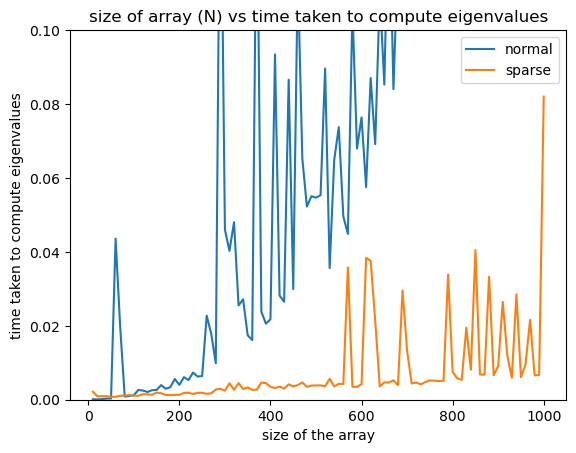

In [430]:
def A(x):
    return -1

def B(x):
    return 0

matrix_sizes = np.arange(10, 1010, 10)
time_taken_sparse = np.zeros(100) # 100 pairs of sparse matrix time and regular matrix time values
time_taken_normal = np.zeros(100)
for i in range(len(matrix_sizes)):
    t1 = time.time()
    M = sparse_matrix(A, B, B, matrix_sizes[i], 1)
    sparse.linalg.eigsh(M, k = 1, sigma = 0)
    t2 = time.time()
    time_taken_sparse[i] = t2 - t1
    t1 = time.time()
    M = matrix_gen(A, B, B, matrix_sizes[i], 1)
    np.linalg.eigh(M)
    t2 = time.time()
    time_taken_normal[i] = t2 - t1

plt.plot(matrix_sizes, time_taken_normal, label = "normal")
plt.plot(matrix_sizes, time_taken_sparse, label = "sparse")
plt.xlabel("size of the array")
plt.ylabel("time taken to compute eigenvalues")
plt.title("size of array (N) vs time taken to compute eigenvalues")
plt.ylim(0, .1)
plt.legend()

As I expected, the sparse matrix generator is more efficient then the original one. We can see this improvement in efficiency as the size of the matrix increases. In the case of the sparse matrix, the runtime scales linearly whereas in the original matrix generator the runtime scales exponentially. Its important to note that the random peaks in the graph are caused by computational rounding errors.

## The Hydrogen Energy Spectrum

<font color = blue>
    
Now we want to analyze the Hydrogen atom, where we are trying to solve the equation (in dimensionless form, as usual)

$$
-u'' + \frac{\ell(\ell+1)}{r^2}u - \frac{2}{r}u + u = \hat{E}u
$$

Remember that here, length is measured in units of the Bohr radius, and energy is measured in units of the Rydberg energy, but with an upward shift of $+1$ so that $\hat{E} = \tilde{E} + 1$ and all of the eigenvalues will come out positive.

The value $\ell$ is the quantum number associated with the magnitude of angular momentum.  With this non-dimensionalization, the energy spectrum should be

$$
\hat{E}_n = 1 - \frac{1}{n^2}, \hspace{.5in} \tilde{E}_n = -\frac{1}{n^2} \, .
$$

### 
Preliminaries

<font color = blue>
    
First create a function that takes as input the value of $\ell$ as well as the choice of "numerical infinity" and the matrix size, and outputs the appropriate (sparse) matrix.

In [436]:
def prelim_matrix(l, x_inf, matrix_size):
    """
    function that outputs the appropriate sparse matrix based on params

    l : quantum number associated with the magnitude of angular momentum
    x_inf : chosen value that represents infinity for the computer
    matrix_size : the size of the matrix we want outputted (matrix_size x matrix_size)

    returns : appropriate sparse matrix based on params
    """
    def A(x):
        return -1
    def B(x):
        return 0
    def C(x):
        if x != 0:
            return ((l * (l + 1)) / ((x**2)) - (2/x) + 1)
        else:
            return 0
    return sparse_matrix(A, B, C, matrix_size, x_inf)

### Eigenvalues

#### * Zero Angular Momentum States

<font color = blue>
    
Now, use your function to genererate the energy spectrum of the lowest ten energies of hydrogen, with $\ell = 0$. Create arrays with entries $[n]$ and $[\tilde{E}_n]$, and plot this together with a curve showing the theoretical spectrum.  (Don't forget to shift the energies back from $\hat{E}$ to $\tilde{E}$!)  For this exercise, use $x_{\infty} = 1000$ and $N = 100000$.  **Discuss** the results.

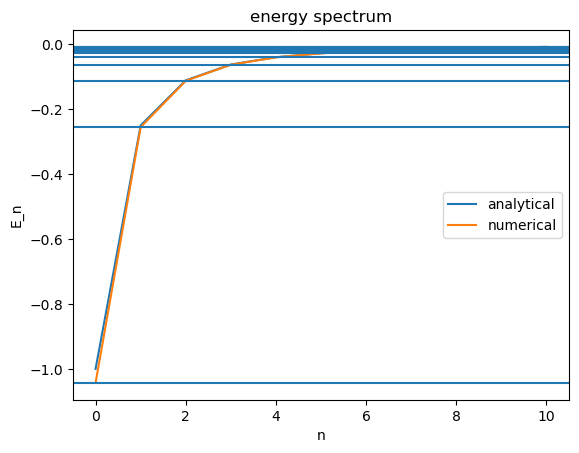

In [440]:
prelim = prelim_matrix(0, 1000, 100000)

def theoretical_spectrum(n): 
        return -1/((n + 0 + 1)**2)

n = np.arange(0, 11, 1)
E = np.array([theoretical_spectrum(item) for item in n])

E_hat, vectors = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
E_num = np.zeros(11)
for i in range(len(E_hat)):
    item = E_hat[i] - 1
    E_num[i] = item

plt.plot(E, label = "analytical")
plt.plot(E_num, label = "numerical")
plt.xlabel("n")
plt.ylabel("E_n")
plt.title("energy spectrum")
for i in range(len(E_num)):
    plt.axhline(E_num[i])
plt.legend()

In this graph, we can see that the slope of the line levels rather quickly at about n = 5. This makes sense because the scale at which the energy is changing between eigenvalues is much less than the scale of the initial energy. We can also see that as we get to a higher n value, the approximation gets closer and closer to the theoretical values. 

#### * Non-Zero Angular Momentum States

<font color = blue>
    
Then, use your function to also generate lists of energies for $\ell = 1$ and $\ell = 2$.  (Use the same $x_{\infty}$ and $N$ values.)

Create a graph showing all three values of $\ell$.  Put energy on the vertical axis, and $\ell$-value on the horizontal axis.  Add horizontal lines at each energy level.  **Discuss** the results.

In [444]:
prelim = prelim_matrix(1, 1000, 100000)

def theoretical_spectrum(n): 
        return -1/((n + 1 + 1)**2)

n = np.arange(0, 11, 1)
E = np.array([theoretical_spectrum(item) for item in n])

E_hat = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
E_num1 = np.zeros(11)
for i in range(len(E_hat[0])):
    item = E_hat[0][i] - 1
    E_num1[i] = item

In [445]:
prelim = prelim_matrix(2, 1000, 100000)

def theoretical_spectrum(n): 
        return -1/((n + 2 + 1)**2)

n = np.arange(0, 11, 1)
E = np.array([theoretical_spectrum(item) for item in n])

E_hat = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
E_num2 = np.zeros(11)
for i in range(len(E_hat[0])):
    item = E_hat[0][i] - 1
    E_num2[i] = item

Text(0.5, 1.0, 'energy spectrum')

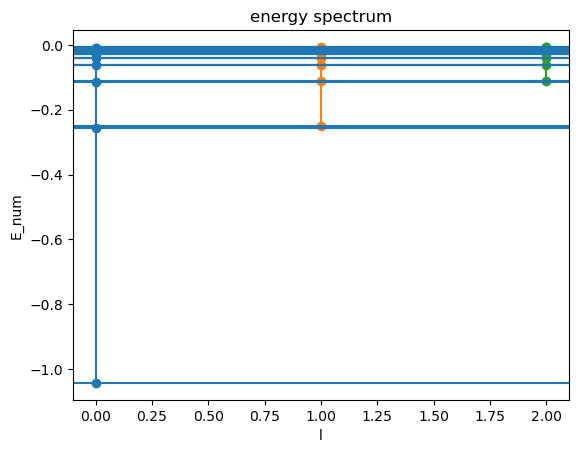

In [446]:
l_vals = np.array([
   np.full(11, 0),
   np.full(11, 1),  
   np.full(11, 2)
])
plt.plot(l_vals[0], E_num, marker = "o")
plt.plot(l_vals[1], E_num1, marker = "o")
plt.plot(l_vals[2], E_num2, marker = "o")
for i in range(len(E_num)):
    plt.axhline(E_num[i])
    plt.axhline(E_num1[i])
    plt.axhline(E_num2[i])

plt.xlabel("l")
plt.ylabel("E_num")
plt.title("energy spectrum")

In these results, we can see most obviously, that we have created a chart that I have seen in a handful of physics classes corresponding to energy spectrums. In this graph we can see that the magnitude of E_num is depending on the sum of the quantum numbers (n, n_r and l). We can also see that the Energies at each respective sum of the quantum numbers is the same regardless of l value or n value.

### Eigenvectors

#### * Anaytlic Comparisons

<font color = blue>
    
Now let's make some comparisons between the eigenvectors generated numerically and the known analytic functions for the radial wavefunction $R(r)$.  Use the "eigsh" function to generate the eigenvectors associated with the sets of quantum numbers $(n = 1, \ell = 0)$, $(n - 2, \ell = 0)$, and $(n = 2, \ell = 1)$.  For this, use $x_{\infty} = 1000$ and $N = 100000$.  Convert these lists into discrete approximations of the radial wavefunction

$$
R(r) = \frac{u(r)}{r}
$$

In addition, create a list of $r$-coordinates $[r_n]$.  Then plot each, together with its analytic, known solution:

$$
n = 1, \ell = 0: \hspace{.5in} R(r) \propto e^{-r}
$$

$$
n = 2, \ell = 0: \hspace{.5in} R(r) \propto \left(1 - \frac{r}{2}\right)e^{-r/2}
$$

$$
n = 2, \ell = 1: \hspace{.5in} R(r) \propto r e^{-r/2}
$$

(you will have to manually "tune" a constant of proportionality in each case until it fits well -- wavefunctions are normalized according to a probability requirement, but the eigenvectors will automatically satisfy a different normalization condition.)

**Discuss** the results.

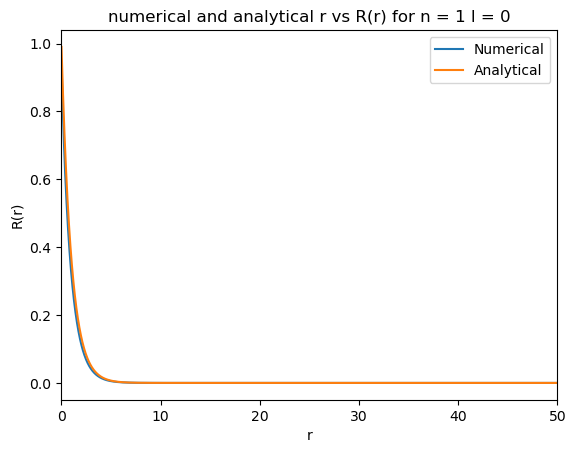

In [451]:
## n = 1, l = 0

def R(r):
    """
    theoretical R(r) equation
    """
    return np.exp(-r)

N = 100000
x_inf = 1000
del_r = x_inf/(N + 1)
prelim = prelim_matrix(0, x_inf, N)
eigenvals, eigenvectors = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
nth_eigenvector = eigenvectors[:, 0]

r_vals = np.linspace(del_r, del_r * N, N)
R_vals = R(r_vals)

def numerical_R(eigenvector, r, A = 4.3):
    return A * (eigenvector / r)

numerical_R_vals = numerical_R(nth_eigenvector, r_vals)

plt.plot(r_vals, numerical_R_vals, label="Numerical")
plt.plot(r_vals, R_vals, label="Analytical")
plt.xlabel("r")
plt.ylabel("R(r)")
plt.title("numerical and analytical r vs R(r) for n = 1 l = 0")
plt.xlim(0, 50)
plt.legend()

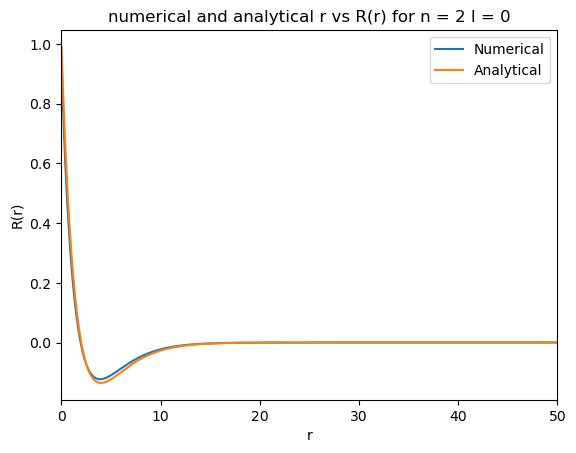

In [452]:
## n = 2, l = 0

def R(r):
    """
    theoretical R(r) equation
    """
    return (1 - (r/2)) * np.exp(-r/2)

prelim = prelim_matrix(0, x_inf, N)
eigenvals, eigenvectors = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
nth_eigenvector = eigenvectors[:, 1]

r_vals = np.linspace(del_r, del_r * N, N)
R_vals = R(r_vals)

def numerical_R(eigenvector, r, A = 12.45):
    return A * (eigenvector / r)

numerical_R_vals = numerical_R(nth_eigenvector, r_vals)

plt.plot(r_vals, numerical_R_vals, label="Numerical")
plt.plot(r_vals, R_vals, label="Analytical")
plt.xlim(0, 50)
plt.xlabel("r")
plt.ylabel("R(r)")
plt.title("numerical and analytical r vs R(r) for n = 2 l = 0")
plt.legend()

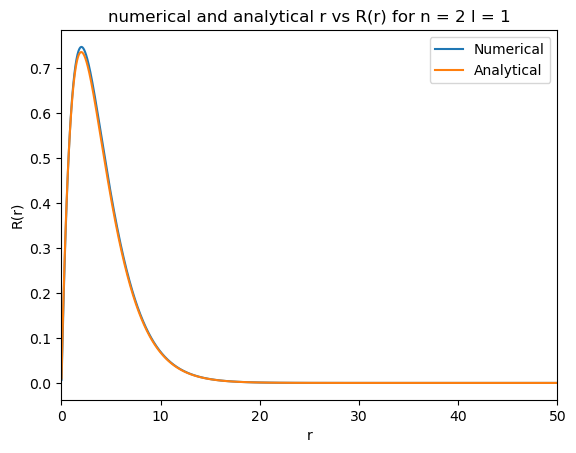

In [453]:
## n = 2, l = 1

def R(r):
    """
    theoretical R(r) equation
    """
    return r * np.exp(-r/2)

prelim = prelim_matrix(1, x_inf, N)
eigenvals, eigenvectors = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
nth_eigenvector = eigenvectors[:, 0]

r_vals = np.linspace(del_r, del_r * N, N)
R_vals = R(r_vals)

def numerical_R(eigenvector, r, A = 50):
    return A * (eigenvector / r)

numerical_R_vals = numerical_R(nth_eigenvector, r_vals)

plt.plot(r_vals, numerical_R_vals, label="Numerical")
plt.plot(r_vals, R_vals, label="Analytical")
plt.xlabel("r")
plt.ylabel("R(r)")
plt.title("numerical and analytical r vs R(r) for n = 2 l = 1")
plt.xlim(0, 50)
plt.legend()

Within these results there are a few interesting things to discuss. Firstly, a bit besides the point but there seems to be some random sign introduced by the eigsh function so at times the numerical results will be reflected about the x axis. Secondly, we can see that the constant we introduce to account for normalization increases as the sum of the quantum numbers increases (this has something to do with normalization conditions within eigsh). lastly, we can see that the graphs flatten quicker when the magnitude of the quantum numbers is lower meaning that with higher quantum numbers we are more likely to find an electron farther away.

#### The Role of $\Delta x$

<font color = blue>
    
We would now like to examine the roll that $\Delta x$ plays in limiting the accuracy and applicability of our numerical method.  To do so, consider the radial wavefunction $R(r)$ with $n = 4$ and $\ell = 1$.  Create plots of this wavefunction for different values of `matrix_size` = $N$:

$$N = \{100000, 10000, 1000, 100\}$$

all with $x_{\infty} = 1000.$  (Note that the normalization of the eigenvector will change as you change $N$.)

This corresponds to four different choices of $\Delta x$.  **Discuss** the results.  What, in general, must be true of $\Delta x$ in order for the finite different method to work well (on a particular wavefunction)?

In [457]:
## n = 4 l = 1
sizes = np.array([100, 1000, 10000, 100000])
x_inf = 1000

prelim_1 = prelim_matrix(0, x_inf, sizes[0])
prelim_2 = prelim_matrix(0, x_inf, sizes[1])
prelim_3 = prelim_matrix(0, x_inf, sizes[2])
prelim_4 = prelim_matrix(0, x_inf, sizes[3])

eigenvals1, eigenvectors1 = sparse.linalg.eigsh(prelim_1, k = 11, sigma = 0)
eigenvals2, eigenvectors2 = sparse.linalg.eigsh(prelim_2, k = 11, sigma = 0)
eigenvals3, eigenvectors3 = sparse.linalg.eigsh(prelim_3, k = 11, sigma = 0)
eigenvals4, eigenvectors4 = sparse.linalg.eigsh(prelim_4, k = 11, sigma = 0)

nth_eigenvector1 = eigenvectors1[:, 2]
nth_eigenvector2 = eigenvectors2[:, 2]
nth_eigenvector3 = eigenvectors3[:, 2]
nth_eigenvector4 = eigenvectors4[:, 2]

del_r1 = x_inf/(sizes[0] + 1)
r_vals1 = np.linspace(del_r1, del_r1 * sizes[0], sizes[0])
del_r2 = x_inf/(sizes[1] + 1)
r_vals2 = np.linspace(del_r2, del_r2 * sizes[1], sizes[1])
del_r3 = x_inf/(sizes[2] + 1)
r_vals3 = np.linspace(del_r3, del_r3 * sizes[2], sizes[2])
del_r4 = x_inf/(sizes[3] + 1)
r_vals4 = np.linspace(del_r4, del_r4 * sizes[3], sizes[3])

def numerical_R(eigenvector, r, D = 4.3):
    return D * (eigenvector / r)

numerical_R_vals1 = numerical_R(nth_eigenvector1, r_vals1)
numerical_R_vals2 = numerical_R(nth_eigenvector2, r_vals2)
numerical_R_vals3 = numerical_R(nth_eigenvector3, r_vals3)
numerical_R_vals4 = numerical_R(nth_eigenvector4, r_vals4)

<function matplotlib.pyplot.show(close=None, block=None)>

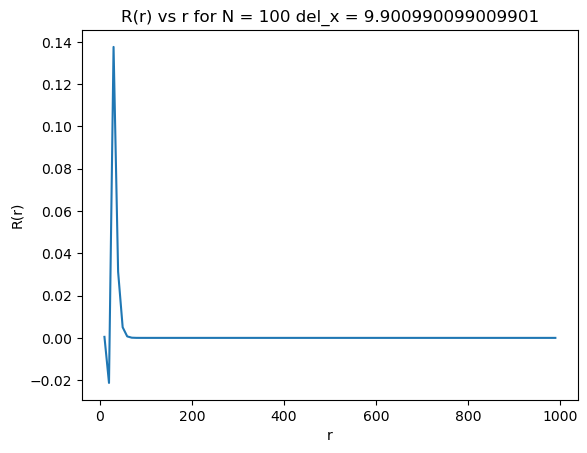

In [458]:
plt.plot(r_vals1, numerical_R_vals1, label=f"N = 100 del_x = {del_r1}")
plt.title(f"R(r) vs r for N = 100 del_x = {del_r1}")
plt.xlabel("r")
plt.ylabel("R(r)")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

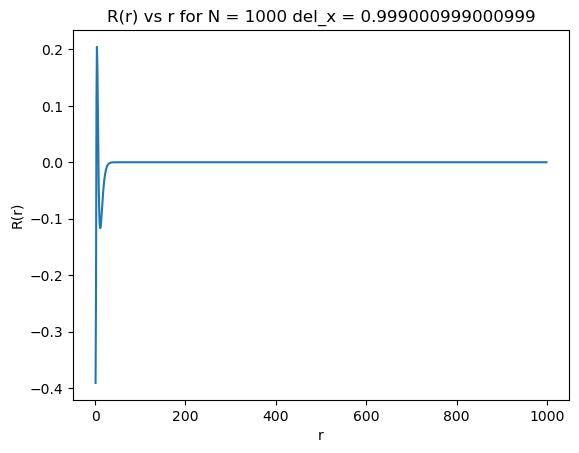

In [459]:
plt.plot(r_vals2, numerical_R_vals2, label=f"N = 1000 del_x = {del_r2}")
plt.title(f"R(r) vs r for N = 1000 del_x = {del_r2}")
plt.xlabel("r")
plt.ylabel("R(r)")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

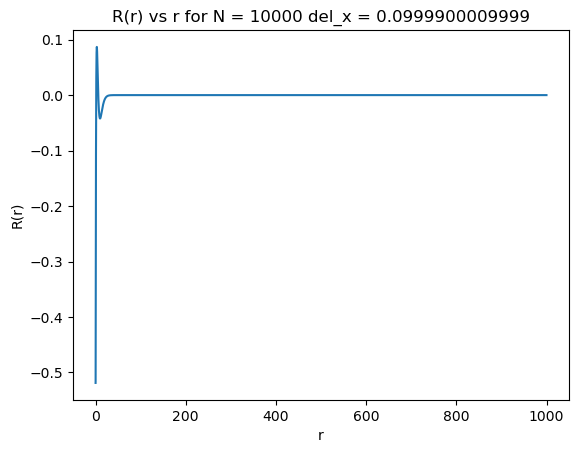

In [460]:
plt.plot(r_vals3, numerical_R_vals3)
plt.title(f"R(r) vs r for N = 10000 del_x = {del_r3}")
plt.xlabel("r")
plt.ylabel("R(r)")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

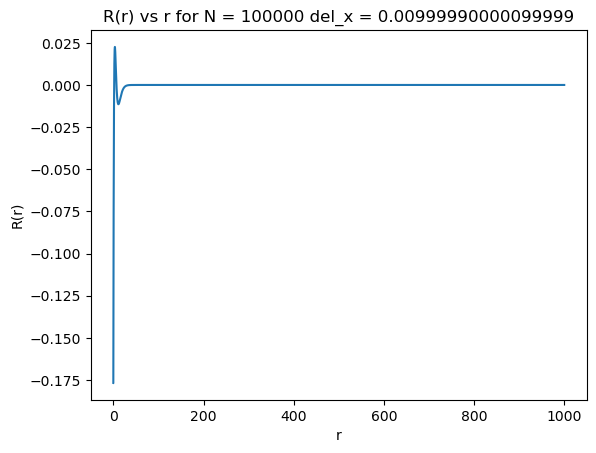

In [461]:
plt.plot(r_vals4, numerical_R_vals4)
plt.title(f"R(r) vs r for N = 100000 del_x = {del_r4}")
plt.xlabel("r")
plt.ylabel("R(r)")
plt.show

By looking at the results, it is clear to see what delta x must be in order for the finite difference method to work. What I see, is that delta x must be sufficiently small in relation to the range of r values where R(r) is varying greatly. For example, in this case, if we zoom in on the graph of the final approximation, we can see that the function is changing large amounts within r = 0 and r $\approx$ 20. Therefore since del_x << 20 this approximation is fairly accurate. Note that the smaller delta x gets the more rounding error we will get (but this is besides the point).

#### The Role of $x_{\infty}$

<font color = blue>
    
Now let's consider the first 10 eigenstates with $\ell = 0$, but use $x_{\infty} = 100$ and $N = 10000$ (notice that we have kept the spacing $\Delta x$ roughly the same as in our original work.)  First, find the lowest ten energy eigenvalues.  What is strange (and not correct) about the last couple?  Generate the actual eigenvector corresponding to the 10th eigenvalue, and then generate it again with $x_{\infty} = 1000$ and $N = 100000$, and plot the two (in this case, it's more useful to plot $u(r)$ than to plot $R(r)$.)  **Discuss** the results.  What must be true of the choice of numerical infinity, in order for the eigenfunction and eigenvalue to be effectively estimated?

[-1.04327056 -0.25531806 -0.11267831 -0.0631594  -0.04033703 -0.02793566
 -0.01937157 -0.00955723  0.00302703  0.01819984  0.03578834]


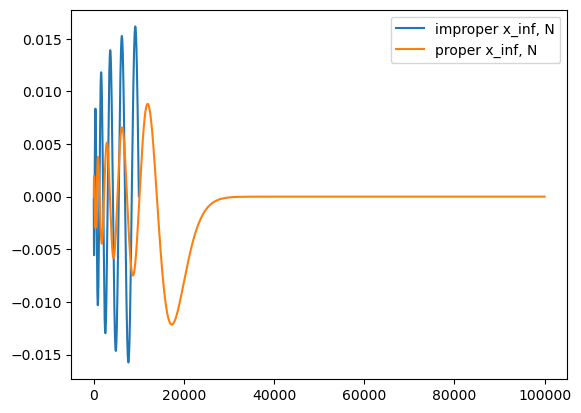

In [506]:
x_inf = 100
N = 10000
del_x = x_inf/(N + 1) 
r_vals = np.linspace(del_x, del_x * N, N)
prelim = prelim_matrix(0, x_inf, N)

E_hat, vectors = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
E_num = np.zeros(11)
tenth_eigenvalue_bad_way = vectors[:, 9]
for i in range(len(E_hat)):
    item = E_hat[i] - 1
    E_num[i] = item

x_inf = 1000
N = 100000
del_x = x_inf/(N + 1) 
r_vals = np.linspace(del_x, del_x * N, N)
prelim = prelim_matrix(0, x_inf, N)

E_hat, vectors = sparse.linalg.eigsh(prelim, k = 11, sigma = 0)
tenth_eigenvalue_good_way = vectors[:, 9]

print(E_num)
plt.plot(tenth_eigenvalue_bad_way, label = "improper x_inf, N")
plt.plot(tenth_eigenvalue_good_way, label = "proper x_inf, N")
plt.xlabel("r")
plt.ylabel("u(r)")
plt.legend()

When looking at the eigenvalues, I can see that it is incorrect because the energies go from negative to positive (which clearly makes no sense because it implies negative energy which is not possible for this system). Next, in the graph we can see that the improper x_inf value plot gives us a function that doesn't satisfy our boundary conditions because it does not go to zero as it approaches infinity. This leads me to my conclusion about x_inf which is that it must be a large enough value to let the function that we are approximating go to zero (to satisfy this boundary condition).

## The Numerical Algorithms for the Heat Equation

<font color = blue>
We want code that will solve (find $\tau(s)$) for the generic heat equation
    $$
    \lambda(s)\tau''(s) + \lambda'(s)\tau'(s) = -h(s)
    $$
where the functions $\lambda(s)$ and $h(s)$ are given, and the boundary conditions for $\tau(s)$ are:
    $$
    \tau(0) = 0 \, , \hspace{.5in} \tau(1) = 1
    $$
In order to do this, we convert the equation into a matrix problem of the form
    $$
    \mathbb{M}\vec{\tau} = -(\vec{h} + \vec{b})
    $$

(where the matrix $\mathbb{M}$ encodes the differential operator on the right-hand-side, the vector $\vec{h}$ encodes the source function, and the vector $\vec{b}$ encodes the boundary conditions).

### Generating the Matrix

<font color = blue>
    
Create a function that will build the matrix $\mathbb{M}$.  Your matrix should take as inputs the size of the matrix (that is, of the spatial grid), and the function $\lambda(s)$, and should use produce a sparse array.  You should be able to start with the function you created in the previous part of the assignment and create a function which uses it.  Use a symmetric numerical derivative to find the function $\lambda'(s)$ with an $\epsilon$ parameter set to be 1/100 of the grid spacing.

### Generating the Source Vector

<font color = blue>
    
Create a function that will build the vector $\vec{h}$.  It should take as inputs the size of the vector and the source function $h(s)$.  (Note that this is not typically sparse, so there's no point in using that technology).

### Generating the Boundary Vector

<font color = blue>
Create a function that generates the vector $\vec{b}$ in which you will encode your boundary conditions.  It should take as inputs the size of the vector and the source function $\lambda(s)$, and use the same mechanism as before to calculate the numerical derivative $\lambda'(s)$.  

```
```

We could work hard at this and generate this in sparse form, but it turns out not to be super-important.  The "sparse" structure is designed to make sure we don't use up memory space in the computer storing a bunch of zeroes: instead we only store those elements of the matrix or vector which are non-zero.  But in this problem the matrix you have just created will have of order $N$ non-zero elements.  If we now store all $N$ elements of the vector $\vec{b}$, even those which aren't zero, we haven't changed the scaling of the number of values we are storing (it is still just of order $N$).

### The Solution Maker

<font color = blue>
We now want to use these pieces to create solutions to our differential equation

#### Solution Function

<font color = blue>
    Write a function that will take as inputs the size of the grid $N$, the source function $h(s)$ and conductivity $\lambda(s)$, and will output the solution to the differential equation in the form of two lists $[s_i]$ and $[\tau_i]$.  Your function should use the function scipy.sparse.linalg.inv to invert the matrix.

#### A Simple Test

<font color = blue>
Test your function with the case $\lambda(s) = 1$ and $h(s) = 0$, using $N = 1000$.  Confirm that the solution matches the expected analytic solution $\tau(s) = s$.

## * Exploring the Heat Equation

<font color = blue>
    Now that we have the basic elements to produce solutions to the heat equation in 1D, we want to experiment with them.

### Linearly Varying Conductivity

<font color = blue>
   Consider the case where the conductivity of the rod varies linearly along it, in the form
    $$
    \lambda(s) = 1 + \beta s
    $$
    but there is still no source term.

#### Comparing with the Analytic Solution

<font color = blue>
In this case, it is also possible to find the solution analytically, and it is given by

$$
\tau(s) = \frac{\ln(1 + \beta s)}{\ln(1 + \beta)}
$$
    
Use your algorithm to find a solution for $\beta = 1$, and graph it together with the analytic solution.  **Discuss** the results.

#### Varying $\beta$

<font color = blue>
    
Now create a graph which shows the solutions for $\beta = -0.99, -0.9, 0, 10, 100$.   **Discuss** the results.

### Sinusoidally Varying Conductivity

<font color = blue>
    
Now let's consider the case where the conductivity varies sinusoidally across the rod (so parts of the rod which have high conductivity are interspersed with parts of the rod which have low conductivity).  Let's say
    $$
    \lambda(s) = 1 + A\sin(k s)
    $$
where $A = 0.99$ and $k = 20$.  Create plots of both the conductivity itself and the temperature across the rod.   **Discuss** the results.

### Source Terms

<font color = blue>
    Now consider a rod with constant conductivity $\lambda(s) = 1$, but with a non-trivial source term in the form
    $$
    h(s) = \frac{h_0}{\sigma\sqrt{\pi}}e^{-(s - s_0)^2/\sigma^2}
    $$
    
This Gaussian function is appropriate for modeling sources that are nearly point-like, with $s_0$ giving the location of the source, $h_0$ giving its strength, and $\sigma$ giving the width it is spread out over.  (Choosing $\sigma$ small makes it closer to a point-like source).

#### The Significance of $h_0$

<font color = blue>
Create a single graph that shows solutions with $\sigma = 0.01$ and $s_0 = 0.5$, but with $h_0$ in the set

$$
h_0 \in \{-10, 1, 0, 1, 10\}
$$

 **Discuss** the results.

#### The Significance of $s_0$

<font color = blue>
    Now create a graph that shows solutions where $h_0 = 10$ and $\sigma = 0.01$, but
    
$$
s_0 \in \{0.25, .5, 0.75\}
$$

 **Discuss** the results.

#### The Significance of $\sigma$

<font color = blue>
    Finally, create a graph that shows solutions with $h_0 = 10$ and $s_0 = 0.5$, but with
    
$$
\sigma =\in \{0.5, 0.1, 0.05, 0.01, 0.005\}
$$

 **Discuss** the results.

## Final Project Work

<font color = blue>
    
This week, you should submit your progress on your final project, in a separate Jupyter notebook.  Your notebook should be organized the same way these assignments are (broken into sections, code correctly commented and documented, and short discussions after each section.)  Keep in mind that depending on the topic of your project, I may have very little experience with it, which means your discussions need to be that much better!

At the end, include a brief discussion of what you *intended* to accomplish as compared with what you *did* accomplish, as well as a plan of what you intend to do in the next **week**.